In [57]:
from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as prep
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tabulate import tabulate

In [58]:
def mean_square_error(y, y_hat):
    return np.mean(np.square(np.array(y-y_hat)))

class LinearModel:
    def __init__(self):
        self.beta = None

    def fit(self, x,y):
        X = np.concatenate((np.ones((x.shape[0], 1)), x), axis = 1)
        self.beta = np.linalg.solve((X.T @ X),X.T @ y)
        return self.beta

    def predict(self,x, with_intercept = True):
        if with_intercept:
            X = np.concatenate((np.ones((x.shape[0], 1)),x), axis = 1)
            y_hat = X @ self.beta
        else:
            y_hat = x @ self.beta[1:]
        return y_hat
class RidgeModel(LinearModel):
  def __init__(self, lambd):
    self.lambd = lambd
    self.beta = None

  def fit(self, x,y):
    X = np.concatenate((np.ones((x.shape[0], 1)),x), axis = 1)
    self.beta  = np.linalg.solve(X.T @ X + self.lambd*np.eye(X.shape[1]),X.T@y)
    return self.beta

def weighted_error(lam, y, y_hat, beta):
  return mean_square_error(y, y_hat) + lam*np.sum(np.array(beta[1:])**2)


In [59]:
def train_val_test_split(x, y, test_percent, val_percent, random_state = None):
    rel_val_percent = np.round((val_percent)/(1-test_percent), 2)

    x_inter, x_test, y_inter, y_test = train_test_split(x, y, test_size = test_percent, random_state = random_state)
    x_train, x_val, y_train, y_val = train_test_split(x_inter, y_inter, test_size = rel_val_percent, random_state = random_state)
    
    return x_train, x_val, x_test, y_train, y_val, y_test

def normalize(x_train, x_val, x_test): 
    x_train = (x_train - x_train.mean(axis=0)) / x_train.std(axis=0)
    x_val = (x_val - x_val.mean(axis=0)) / x_val.std(axis=0)
    x_test = (x_test - x_test.mean(axis=0)) / x_test.std(axis=0)
    return x_train, x_val, x_test

def predict(x_train, y_train, x_test, y_test, linearModel): 
    beta = linearModel.fit(x_train, y_train)
    test_error = mean_square_error(y_test, linearModel.predict(x_test))
    train_error = mean_square_error(y_train, linearModel.predict(x_train))
    print("Test MSE:", test_error)
    print('\n')
    return beta

def format_corr_table(corr_mat, coeff_names):
  corr_table = []
  for row_num in range(corr_mat.shape[0]):
    vals = list(corr_mat[row_num, :])
    vals = [str(round(val,3)) for val in vals]
    vals.insert(0,coeff_names[row_num])
    vals = vals [:row_num+1]
    corr_table.append(vals)
  return corr_table

def correlation_table(x_train): 
    corr_mat = np.corrcoef(x_train.T)
    coeff_names = list(df_prostate.columns.values[:-1])
    corr_table = format_corr_table(corr_mat, coeff_names)
    coeff_names.insert(0,'Coefficients')
    corr = tabulate(corr_table[1:], headers=coeff_names, tablefmt='pretty')
    print('     Table 1: Correlations of predictors in the prostate cancer data.')
    print(corr)
    print('\n')

def z_scorer(model, X, y):
    N = len(X)
    p = X.shape[1]
    sigma =  np.sqrt(np.sum((y - model.predict(X))**2)/(N-p-1))
    X = np.concatenate((np.ones((N, 1)),X), axis = 1)
    sqrt_v = np.sqrt(np.diagonal(np.linalg.inv(X.T @ X)))
    standard_error = sigma*sqrt_v
    z_score = model.beta/standard_error
    return standard_error, z_score

def format_lin_summary_table(term, beta, s_e, z_scr, round_decimal = 2):
  summary_mat = []
  for coeff_num in range(len(term)):
    row = list([term[coeff_num],
              round(beta[coeff_num], round_decimal),
              round(s_e[coeff_num], round_decimal),
              round(z_scr[coeff_num], round_decimal)])
    summary_mat.append(row)
  return summary_mat

def stats_table(linearModel, x_train, y_train, beta, df):
    standard_error, Z_score = z_scorer(linearModel, x_train, y_train)
    term = list(df.columns.values[:-1])
    term.insert(0, 'Intercept')
    summary_lst = format_lin_summary_table(term, beta, standard_error, Z_score)
    summary_header = ['Term', 'Coefficient', 'Std. Error', 'Z Score']
    summary = tabulate(summary_lst, headers = summary_header, tablefmt='pretty')
    print('Table 2: Linear model fit to the prostate cancer data.')
    print(summary)
    print('\n')

def perform_linear_regression(x_train, y_train, x_test, y_test, df): 
    #prediction
    linearModel = LinearModel()
    beta = predict(x_train, y_train, x_test, y_test, linearModel)

    #table 3.1
    correlation_table(x_train)
    
    #table 3.2
    stats_table(linearModel, x_train, y_train, beta, df)

def get_weights(Lassomodel):
  wght = np.zeros((len(Lassomodel.coef_)+1))
  wght[0] = Lassomodel.intercept_
  wght[1:] = Lassomodel.coef_
  return list(wght)

def optimize_parameter(model, param_range, X_train, y_train, X_val, y_val, df):
  best_val_err = float('inf')
  opt_param = None
  weights = {}

  for param in param_range:
    newmodel = model(param)
    newmodel.fit(X_train,y_train)
    try: 
      weights[param] = list(newmodel.beta)
    except: 
      newmodel.fit(X_train,y_train)
      weights[param] = get_weights(newmodel)

    err_val = weighted_error(param, y_val, newmodel.predict(X_val), weights[param])
    if err_val < best_val_err: 
      best_val_err = err_val
      opt_param = param

  return opt_param, best_val_err, weights

def perform_ridge_regression(x_train, y_train, x_test, y_test, x_val, y_val, df):
    N = 1000
    lamrange = np.logspace(-9, 4, N)

    opt_lambda_ridge, valMSE_ridge, weights = optimize_parameter(RidgeModel,
                                                             lamrange,
                                                             x_train,
                                                             y_train,
                                                             x_val,
                                                             y_val, df)

    opt_ridgemodel = RidgeModel(opt_lambda_ridge)
    opt_beta_ridge = opt_ridgemodel.fit(x_train, y_train)
    
    test_error_ridge = mean_square_error(y_test, opt_ridgemodel.predict(x_test))
    train_error_ridge = mean_square_error(y_train, opt_ridgemodel.predict(x_train))
    
    print('MSE from test data:',test_error_ridge)
    print('\n')

    p = len(weights[lamrange[0]])
    coeffs = np.zeros((N,p))

    for i in range(len(lamrange)):
        coeffs[i,:] = weights[lamrange[i]]

    term = list(df.columns.values[:-1])
    term.insert(0, 'Intercept')
    plt.figure
    plt.figure(figsize=(15,7.5),) 
    ax = plt.gca()
    for i in range(p):
        ax.plot(lamrange,coeffs[:,i])
    
    ax.set_xscale('log')
    ax.set_xlim(ax.get_xlim()[::-1])  

    plt.title('Figure 1: Profiles of ridge coefficients for the prostate cancer example, as the tuning parameter λ is varied')
    plt.ylabel('Coefficients')
    plt.xlabel('$\lambda$')
    ymin, ymax = plt.ylim()
    plt.legend(term, bbox_to_anchor=(1.05, 1), loc='upper left',)
    plt.ylim([ymin,ymax])

    plt.vlines(opt_lambda_ridge, ymin, ymax, linestyle='dashed', colors='red')
    plt.show()
    print('\nBest lambda found:', opt_lambda_ridge)

def perform_lasso_regression(x_train, y_train, x_test, y_test, x_val, y_val, df):
    N = 1000
    alpharange = np.logspace(-9, 2, N)

    opt_alpha_lasso, valMSE_lasso,weights_lasso = optimize_parameter(lm.Lasso,
                                                                    alpharange,
                                                                    x_train,
                                                                    y_train,
                                                                    x_val,
                                                                    y_val, df)
    #generating a model using the optimal alpha
    opt_lassomodel = lm.Lasso(alpha = opt_alpha_lasso)
    opt_lassomodel.fit(x_train,y_train)

    #MSEs
    testMSE_lasso= mean_square_error(y_test, opt_lassomodel.predict(x_test))
    trainMSE_lasso = mean_square_error(y_train, opt_lassomodel.predict(x_train))

    #printing MSE
    print('MSE from test data:', testMSE_lasso)

    #initialize 
    p = 9 if df.columns[0] == 'lcavol' else 7
    coeffs = np.zeros((N, p))
    # coeff for each df
    for i in range(len(alpharange)):
        coeffs[i,:] = weights_lasso[alpharange[i]]
    
    # Plotting
    term = list(df.columns.values[:-1])
    plt.figure
    plt.figure(figsize=(15,7.5)) 
    for i in range(0,p):
        plt.plot(alpharange,coeffs[:,i])

    plt.xscale('log')
    plt.gca().invert_xaxis()
    plt.title('Figure 2: Profiles of lasso coefficients.')
    plt.ylabel('Coefficients')
    plt.xlabel('$\lambda$')
    ymin, ymax = plt.ylim()
    plt.legend(term, bbox_to_anchor=(1.05, 1), loc='upper left',)
    plt.ylim([ymin,ymax])


    #adding a line for the best lambda value
    plt.vlines(opt_alpha_lasso, ymin, ymax, linestyle='dashed', colors='red')

    plt.show()

    #print the best lambda value
    print('Best alpha found:', opt_alpha_lasso)

def perform_anal_on_prostate(x, y, df): 
    #training/validation/test setup
    x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(x, y, 0.1, 0.1, np.random.randint(1, 31475 + 1))

    #normalize
    x_train, x_val, x_test = normalize(x_train, x_val, x_test)

    perform_linear_regression(x_train, y_train, x_test, y_test, df)
    perform_ridge_regression(x_train, y_train, x_test, y_test, x_val, y_val, df)
    perform_lasso_regression(x_train, y_train, x_test, y_test, x_val, y_val, df)


In [60]:
df_prostate = pd.read_csv('prostate.data',
                 delimiter='\t',
                 index_col = 0)
df_prostate = df_prostate.iloc[:,:-1]
prostate_data = df_prostate.to_numpy().astype('float')
df_estate = pd.read_csv("Real estate.csv")

df_estate = df_estate.iloc[:,:-1]
estate_data = df_estate.to_numpy().astype('float')

Test MSE: 1.2428561251268453


     Table 1: Correlations of predictors in the prostate cancer data.
+--------------+--------+---------+-------+--------+-------+-------+---------+
| Coefficients | lcavol | lweight |  age  |  lbph  |  svi  |  lcp  | gleason |
+--------------+--------+---------+-------+--------+-------+-------+---------+
|   lweight    | 0.324  |         |       |        |       |       |         |
|     age      | 0.213  |  0.341  |       |        |       |       |         |
|     lbph     | -0.061 |  0.476  | 0.312 |        |       |       |         |
|     svi      | 0.502  |  0.185  | 0.118 | -0.12  |       |       |         |
|     lcp      | 0.619  |  0.175  | 0.136 | -0.052 | 0.645 |       |         |
|   gleason    | 0.392  |  0.032  | 0.218 | 0.004  | 0.271 | 0.538 |         |
|    pgg45     |  0.42  |  0.074  | 0.214 | 0.005  | 0.43  | 0.709 |  0.739  |
+--------------+--------+---------+-------+--------+-------+-------+---------+


Table 2: Linear model fit to

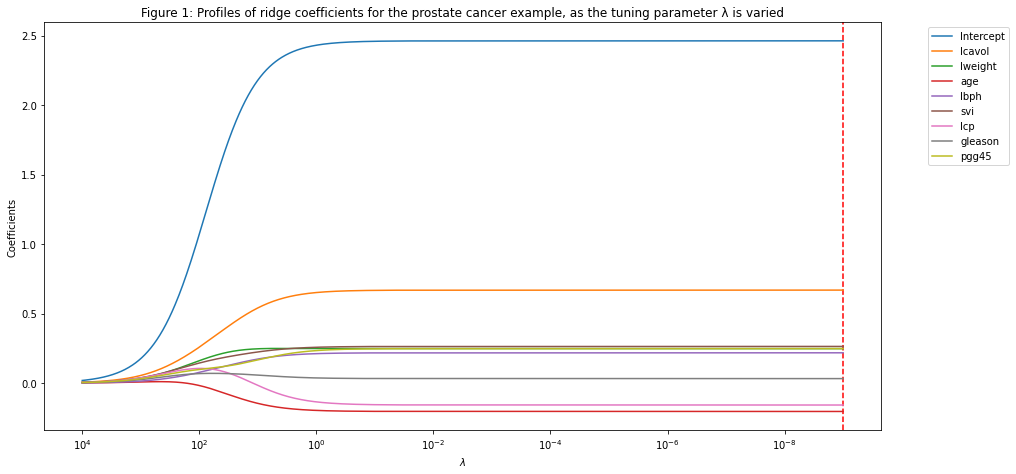


Best lambda found: 1e-09
MSE from test data: 1.2211259434297916


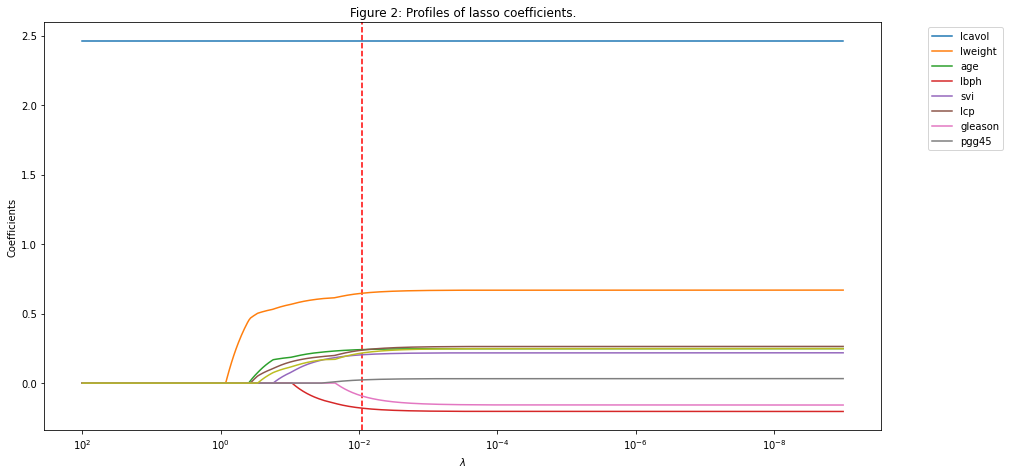

Best alpha found: 0.009098272894455568
Test MSE: 0.00021144094430752152


     Table 1: Correlations of predictors in the prostate cancer data.
+--------------+--------+---------+-------+--------+-------+
| Coefficients | lcavol | lweight |  age  |  lbph  |  svi  |
+--------------+--------+---------+-------+--------+-------+
|   lweight    | -0.032 |         |       |        |       |
|     age      | -0.02  |  0.044  |       |        |       |
|     lbph     | 0.021  |  0.075  | 0.007 |        |       |
|     svi      | -0.009 | -0.031  | 0.045 | -0.631 |       |
|     lcp      | -0.012 |  0.036  | 0.057 | -0.572 | 0.442 |
+--------------+--------+---------+-------+--------+-------+


Table 2: Linear model fit to the prostate cancer data.
+----------------------------------------+-------------+------------+-----------+
|                  Term                  | Coefficient | Std. Error |  Z Score  |
+----------------------------------------+-------------+------------+-----------+
|   

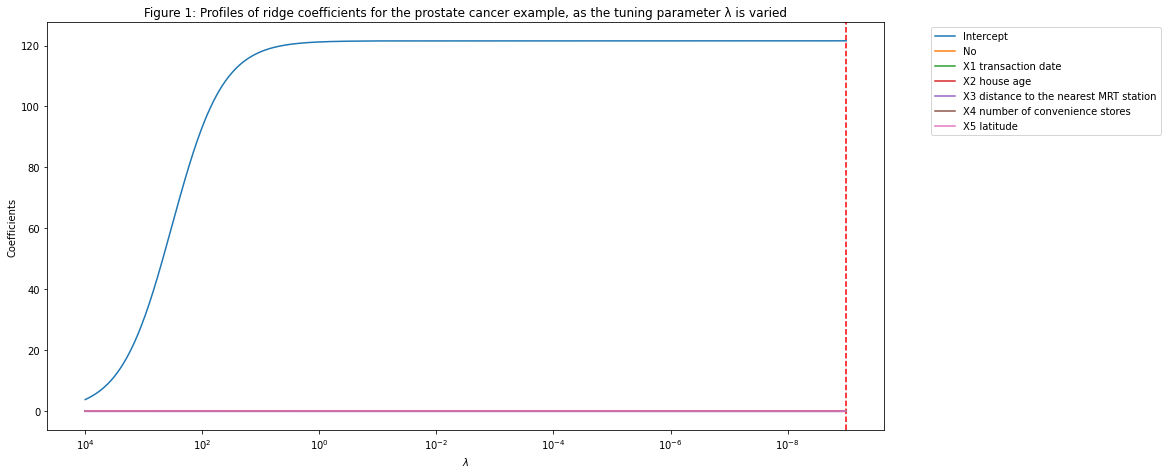


Best lambda found: 1e-09
MSE from test data: 0.00019718507690608982


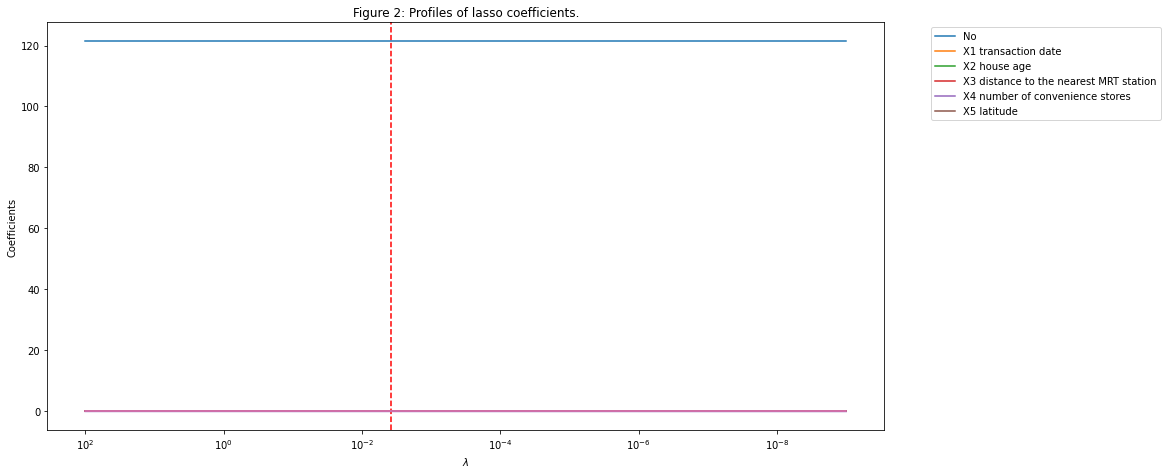

Best alpha found: 0.003842240846055061


In [61]:
perform_anal_on_prostate(prostate_data[:,:-1], prostate_data[:,-1], df_prostate)
perform_anal_on_prostate(estate_data[:,:-1], estate_data[:,-1], df_estate)